In [2]:
import psycopg2 # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
from tqdm import tqdm # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import plotly.graph_objects as go # type: ignore
import yfinance as yf # type: ignore
import os
import warnings
warnings.filterwarnings("ignore")
os.chdir("../../database")
list_ = os.listdir()

# database: price_fund 
parquet_price_fund = []
for i in list_:
    if "tw_price_fund" in i:
        parquet_price_fund.append(i)        
df_list = [pd.read_parquet(i) for i in parquet_price_fund]
unpivoted_df = pd.concat(df_list)
# database: maincode_fund
fund_type_code_df = pd.read_csv("tw_maincode_fund__2025.csv")[['code', "fund_type_code"]]

In [151]:
type_ = "AC23"
list_certain_type = [str(i) for i in fund_type_code_df[fund_type_code_df['fund_type_code'] == type_].code]
typed_df = unpivoted_df[unpivoted_df['code'].isin(list_certain_type)]
pivoted_df = typed_df.pivot_table(index='da', values='nav', columns="code")

In [104]:
# by specific period
def easy_breakout(df, top_n=3, regime = 90):
    tdf = df.ffill().fillna(0)
    
    pct_change = tdf.pct_change()
    pct_change[(pct_change > 0.1) | (pct_change < -0.1)] = 0 
   
    holdings = []
    cumulative_returns = pd.DataFrame(index=tdf.index)  

    for i in range(1, len(tdf)):
        cumulative_returns = cumulative_returns.shift(1).fillna(0) + pct_change
        best_stocks = cumulative_returns.iloc[i].nlargest(top_n).index 
        holdings.append(list(best_stocks)) 
    
    i = 20
    pct_change = pct_change.shift(i)
    pct_change['Best_Holding'] = [None] + holdings
    holds = ""
    holdings_dict = {}
    
    for index, row in pct_change[['Best_Holding']].iterrows():
        if row['Best_Holding'] == None: continue
        current_holdings = set(row['Best_Holding']) 
        if holds != current_holdings:
            holdings_dict[index] = current_holdings 
            holds = current_holdings
            
    return holdings_dict

holdings_dict = easy_breakout(pivoted_df, 3, 30)

In [ ]:
def calculate_fund_signal(fund_name, user99, password99, host99, port99, stock_nums=3, period_days=30):
    def get_market_bullbear(cursor):
        sql_bullbear = """
        select da, signal_origin from public.market_bullbear order by da asc 
        """
        cursor.execute(sql_bullbear)
        signal_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
        signal_df.set_index("da", inplace=True)
        return signal_df
    
    def easy_breakout(df, top_n=3, regime = 90):
        tdf = df.ffill().fillna(0)
        
        pct_change = tdf.pct_change()
        pct_change[(pct_change > 0.1) | (pct_change < -0.1)] = 0 
    
        holdings = []
        cumulative_returns = pd.DataFrame(index=tdf.index)  

        for i in range(1, len(tdf)):
            cumulative_returns = cumulative_returns.shift(1).fillna(0) + pct_change
            best_stocks = cumulative_returns.iloc[i].nlargest(top_n).index 
            holdings.append(list(best_stocks)) 
        
        i = 20
        pct_change = pct_change.shift(i)
        pct_change['Best_Holding'] = [None] + holdings
        holds = ""
        holdings_dict = {}
        
        for index, row in pct_change[['Best_Holding']].iterrows():
            if row['Best_Holding'] == None: continue
            current_holdings = set(row['Best_Holding']) 
            if holds != current_holdings:
                holdings_dict[index] = current_holdings 
                holds = current_holdings
                
        prev = None
        new_holding_dict = {}
        for index, holdings in holdings_dict.items():
            if not prev: new_holding_dict[index] = holdings; prev = index; continue;
            if (index - prev).days > regime: new_holding_dict[index] = holdings; prev = index;
            if index == list(holdings_dict.keys())[-1]: new_holding_dict[index] = holdings
        prev = ""
        list_cumsum = []
        for index, (date, holdings) in enumerate(new_holding_dict.items()):
            if index == 0: prev = date; continue;
            # print(pivoted_df)
            cur = pivoted_df[list(holdings)].loc[prev:date]
            cur_nplog = np.log(cur / cur.shift(1)).fillna(0).iloc[1:, :]
            list_cumsum.append(cur_nplog.mean(axis=1))
            prev = date
        return new_holding_dict, pd.concat(list_cumsum)

    conn = psycopg2.connect(database='tw', user=user99, password=password99, host=host99, port=port99)
    cursor = conn.cursor()
    sql_str = """
        select * from price_fund
        where code in 
        ( select distinct code from maincode_fund where fund_type_code = 'AA1')
        and da >='2018-01-01'
        order by da desc;
    """
    cursor.execute(sql_str)
    typed_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
    pivoted_df = typed_df.pivot_table(index='da', values='nav', columns="code")
    signal_df = get_market_bullbear(cursor=cursor)
    holdings_dict, holdings_pct = easy_breakout(pivoted_df, stock_nums, period_days)
    def convert_dict_to_df(holdings_dict):
        records = []
        for date, stocks in holdings_dict.items():
            for stock in stocks:
                records.append([date, stock])

        # Create a DataFrame from the list of records
        df = pd.DataFrame(records, columns=['df', 'code'])
        return df
    holdings_df = convert_dict_to_df(holdings_dict)
    ins_sql99 = ""
    for _, row in holdings_df.iterrows():
        da = row['da']
        cn_pool_code = row['code']
        weight = float(1) / 5  # 假設是平分的權重

        ins_sql99 += f"INSERT INTO model_strategy_stocks_and_weight(DA, STRATEGY_NAME, CODE, WEIGHT) " \
                    f"VALUES('{da}', '{fund_name}', '{cn_pool_code}', '{weight}') " \
                    f"ON CONFLICT ON CONSTRAINT model_strategy_stocks_and_weight_pkey DO NOTHING;"

    # 寫入資料庫
    try:
        db201exec('tw', ins_sql99)
    except Exception as err:
        print(f"Error: {str(err)}")

In [145]:
for index, value in holdings_dict.items():
    print(index, value)

2020-01-03 00:00:00 {'13539952', '13986924', '13984165'}
2020-02-03 00:00:00 {'98639235', '98639111', '98638804'}
2020-03-05 00:00:00 {'18480065', '20081352', '97988636'}
2020-04-06 00:00:00 {'98639887', '98639886', '98638804'}
2020-05-15 00:00:00 {'92002384', '97988636', '73989501'}
2020-06-24 00:00:00 {'81585475', '97988636', '98638805'}
2020-08-10 00:00:00 {'17146752', '19330754', '98638805'}
2020-09-10 00:00:00 {'13986924', '19330754', '98638805'}
2020-10-12 00:00:00 {'13986924', '19330754', '98638805'}
2020-12-09 00:00:00 {'13986924', '19330754', '98638805'}
2021-04-23 00:00:00 {'13986924', '19330754', '98638805'}
2021-05-27 00:00:00 {'19330754', '98638805', '92002244'}
2021-06-28 00:00:00 {'13986924', '98638805', '92002244'}
2021-08-30 00:00:00 {'13986924', '98638805', '73998071'}
2021-10-25 00:00:00 {'13986924', '98638805', '81585242'}
2021-11-25 00:00:00 {'13986924', '19330754', '98638805'}
2021-12-28 00:00:00 {'13986924', '19330754', '98638805'}
2022-02-07 00:00:00 {'13986924'

In [127]:
def pct_change_filtered_using_market_bullbear(holding_pct):
    def get_market_bullbear():
        symbol = "^TWII"
        data = yf.download(symbol, start='2019-01-01', rounding=2, progress=False)

        # params
        tajm = 242
        alpha = 2 / (tajm + 1)
        dip_range = -0.08
        dip_ready_for_buying_the_dip = False
        trading_days_list = list(data.index)
        adding_extreme = 0
        extreme_last_for_days = 25
        extreme_counter = extreme_last_for_days+1

        adding_signal = 0
        signal_threshold = 2
        current_number_of_signal = 0
        signal_last_for_days = 20
        signal_counter = signal_last_for_days+1
        signal_dict = {}
        signal = 1
        short_signal = 0
        for index, da in enumerate(trading_days_list):
            # preprocess
            if index < tajm: continue
            if da.strftime("%Y-%m-%d") == '2020-09-24': 
                
                signal_dict[da] = 1; continue;
            df_day = data[:da].iloc[:, :].copy()



            df_day['pct'] = df_day['Close'].pct_change()
            # df_day['pct'] = (df_day['High']/df_day['Low'])/df_day['Low']
            df_day['power'] = np.power(df_day.pct, 5)
            df_day["power_ema"] = df_day["power"].ewm(alpha=alpha, adjust=False).mean()
            df_day['power_ema_shift1'] = df_day.power_ema.shift(1)
            
            df_day['diff_5d'] = df_day.pct.rolling(5).sum()
            df_day['diff_5d_diff'] = df_day['diff_5d'].diff()
            df_day['signal'] = np.where(
                (df_day["power_ema"] > df_day["power_ema_shift1"] * 1.01) | 
                (df_day["power_ema"] > 0), 
                1, 
                -1
            )
            df_day_last = df_day.tail(1)
            # dominating rule: {extreme_counter} > {extreme_last_for_days}
            if extreme_counter < extreme_last_for_days:
                extreme_counter += 1; 
                signal_dict[da] = signal
                continue;
            elif extreme_counter == extreme_last_for_days: 
                extreme_counter+=1; signal = 1;
            
            # extreme condition: 
            # buy the dip and last for {extreme_last_for_days} days
            if not dip_ready_for_buying_the_dip and df_day_last.diff_5d.values < dip_range:
                dip_ready_for_buying_the_dip = True;
            if dip_ready_for_buying_the_dip and df_day.diff_5d_diff.values[-1] > 0:
                signal = 1 + adding_extreme;
                extreme_counter = 0;
                dip_ready_for_buying_the_dip = False
                signal_dict[da] = signal
                
                continue;
            
            if signal_counter < signal_last_for_days: 
                signal_counter += 1;
                signal_dict[da] = short_signal
                if df_day_last.signal.values == -1: signal_counter = 0;

                continue;
            elif signal_counter == signal_last_for_days: 
                signal_counter += 1;
                signal = 1;
                current_number_of_signal = 0
                
            if df_day_last.signal.values == -1:
                signal = 1 + adding_signal; 
                current_number_of_signal += 1;
            if current_number_of_signal >= signal_threshold: 
                current_number_of_signal = 1
                signal = short_signal;
                signal_counter = 0;

            signal_dict[da] = signal
        return signal_dict
    signal_dict = get_market_bullbear()
    signal_df = pd.DataFrame([signal_dict]).T
    final = pd.concat([signal_df, holding_pct], axis=1)
    final.columns = ['signal', 'pct']
    final.dropna(inplace=True)
    final['filtered_pct'] = final.apply(lambda row: row['pct'] if row['signal'] == 1.0 else 0, axis=1)
    return final

# by specific period
def easy_breakout(df, top_n=3, regime = 90):
    tdf = df.ffill().fillna(0)
    
    pct_change = tdf.pct_change()
    pct_change[(pct_change > 0.1) | (pct_change < -0.1)] = 0 
   
    holdings = []
    cumulative_returns = pd.DataFrame(index=tdf.index)  

    for i in range(1, len(tdf)):
        cumulative_returns = cumulative_returns.shift(1).fillna(0) + pct_change
        best_stocks = cumulative_returns.iloc[i].nlargest(top_n).index 
        holdings.append(list(best_stocks)) 
    
    i = 20
    pct_change = pct_change.shift(i)
    pct_change['Best_Holding'] = [None] + holdings
    holds = ""
    holdings_dict = {}
    
    for index, row in pct_change[['Best_Holding']].iterrows():
        if row['Best_Holding'] == None: continue
        current_holdings = set(row['Best_Holding']) 
        if holds != current_holdings:
            holdings_dict[index] = current_holdings 
            holds = current_holdings
            
    prev = None
    new_holding_dict = {}
    for index, holdings in holdings_dict.items():
        if not prev: new_holding_dict[index] = holdings; prev = index; continue;
        if (index - prev).days > regime: new_holding_dict[index] = holdings; prev = index;
        if index == list(holdings_dict.keys())[-1]: new_holding_dict[index] = holdings
    def from_holdings_dict_to_cumsum_return(new_holding_dict):
        prev = ""
        list_cumsum = []
        for index, (date, holdings) in enumerate(new_holding_dict.items()):
            if index == 0: prev = date; continue;
            cur = pivoted_df[list(holdings)].loc[prev:date]
            cur_nplog = np.log(cur / cur.shift(1)).fillna(0).iloc[1:, :]
            list_cumsum.append(cur_nplog.mean(axis=1))
            prev = date
        return list_cumsum
    print(new_holding_dict)
    list_cumsum = from_holdings_dict_to_cumsum_return(new_holding_dict=new_holding_dict)
    return new_holding_dict, pd.concat(list_cumsum)


fig = go.Figure()
for i in tqdm(range(30, 39, 10)):
    holdings_dict, holding_pct = easy_breakout(pivoted_df, 3, i)
    holding_pct_filtered = pct_change_filtered_using_market_bullbear(holding_pct=holding_pct)
    final = ((1 + holding_pct_filtered['filtered_pct']).cumprod() - 1)


    fig.add_trace(go.Scatter(
        x=final.index,
        y=final.values,
        mode="lines",
        yaxis="y1",
        name="Return regime {}".format(i)
    ))

beck = yf.download("0050.TW", start='2020-01-01', progress=False, rounding=2)[['Adj Close']]
beck = (1 + beck.loc[:].pct_change()).cumprod() - 1
beck.columns = ['pct_change']
fig.add_trace(go.Scatter(
    x=beck.index,
    y=beck["pct_change"],
    name="Benchmark",
    mode="lines",
    line=dict(color="orange"),
    yaxis="y1"
))

fig.update_layout(
    title="and Benchmark Performance",
    xaxis=dict(title="Date"),
    yaxis=dict(
        title="Strategy Return",
        titlefont=dict(color="blue"),
        tickfont=dict(color="blue"),
    ),
    yaxis2=dict(
        title="Benchmark",
        titlefont=dict(color="orange"),
        tickfont=dict(color="orange"),
        overlaying="y", 
        side="right" 
    ),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    template="plotly_white"
)

fig.show()

  0%|          | 0/1 [00:00<?, ?it/s]

{Timestamp('2020-01-03 00:00:00'): {'13539952', '13986924', '13984165'}, Timestamp('2020-02-03 00:00:00'): {'98639235', '98639111', '98638804'}, Timestamp('2020-03-05 00:00:00'): {'18480065', '20081352', '97988636'}, Timestamp('2020-04-06 00:00:00'): {'98639887', '98639886', '98638804'}, Timestamp('2020-05-15 00:00:00'): {'92002384', '97988636', '73989501'}, Timestamp('2020-06-24 00:00:00'): {'81585475', '97988636', '98638805'}, Timestamp('2020-08-10 00:00:00'): {'17146752', '19330754', '98638805'}, Timestamp('2020-09-10 00:00:00'): {'13986924', '19330754', '98638805'}, Timestamp('2020-10-12 00:00:00'): {'13986924', '19330754', '98638805'}, Timestamp('2020-12-09 00:00:00'): {'13986924', '19330754', '98638805'}, Timestamp('2021-04-23 00:00:00'): {'13986924', '19330754', '98638805'}, Timestamp('2021-05-27 00:00:00'): {'19330754', '98638805', '92002244'}, Timestamp('2021-06-28 00:00:00'): {'13986924', '98638805', '92002244'}, Timestamp('2021-08-30 00:00:00'): {'13986924', '98638805', '739

100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


In [80]:
def get_market_bullbear():
    symbol = "^TWII"
    data = yf.download(symbol, start='2019-01-01', rounding=2, progress=False)

    # params
    tajm = 242
    alpha = 2 / (tajm + 1)
    dip_range = -0.08
    dip_ready_for_buying_the_dip = False
    trading_days_list = list(data.index)
    adding_extreme = 0
    extreme_last_for_days = 25
    extreme_counter = extreme_last_for_days+1

    adding_signal = 0
    signal_threshold = 2
    current_number_of_signal = 0
    signal_last_for_days = 20
    signal_counter = signal_last_for_days+1
    signal_dict = {}
    signal = 1
    short_signal = 0
    for index, da in enumerate(trading_days_list):
        # preprocess
        if index < tajm: continue
        if da.strftime("%Y-%m-%d") == '2020-09-24': 
            
            signal_dict[da] = 1; continue;
        df_day = data[:da].iloc[:, :].copy()



        df_day['pct'] = df_day['Close'].pct_change()
        # df_day['pct'] = (df_day['High']/df_day['Low'])/df_day['Low']
        df_day['power'] = np.power(df_day.pct, 5)
        df_day["power_ema"] = df_day["power"].ewm(alpha=alpha, adjust=False).mean()
        df_day['power_ema_shift1'] = df_day.power_ema.shift(1)
        
        df_day['diff_5d'] = df_day.pct.rolling(5).sum()
        df_day['diff_5d_diff'] = df_day['diff_5d'].diff()
        df_day['signal'] = np.where(
            (df_day["power_ema"] > df_day["power_ema_shift1"] * 1.01) | 
            (df_day["power_ema"] > 0), 
            1, 
            -1
        )
        df_day_last = df_day.tail(1)
        # dominating rule: {extreme_counter} > {extreme_last_for_days}
        if extreme_counter < extreme_last_for_days:
            extreme_counter += 1; 
            signal_dict[da] = signal
            continue;
        elif extreme_counter == extreme_last_for_days: 
            extreme_counter+=1; signal = 1;
        
        # extreme condition: 
        # buy the dip and last for {extreme_last_for_days} days
        if not dip_ready_for_buying_the_dip and df_day_last.diff_5d.values < dip_range:
            dip_ready_for_buying_the_dip = True;
        if dip_ready_for_buying_the_dip and df_day.diff_5d_diff.values[-1] > 0:
            signal = 1 + adding_extreme;
            extreme_counter = 0;
            dip_ready_for_buying_the_dip = False
            signal_dict[da] = signal
            
            continue;
        
        if signal_counter < signal_last_for_days: 
            signal_counter += 1;
            signal_dict[da] = short_signal
            if df_day_last.signal.values == -1: signal_counter = 0;

            continue;
        elif signal_counter == signal_last_for_days: 
            signal_counter += 1;
            signal = 1;
            current_number_of_signal = 0
            
        if df_day_last.signal.values == -1:
            signal = 1 + adding_signal; 
            current_number_of_signal += 1;
        if current_number_of_signal >= signal_threshold: 
            current_number_of_signal = 1
            signal = short_signal;
            signal_counter = 0;

        signal_dict[da] = signal
    return pd.DataFrame([signal_dict]).T

signal_df = get_market_bullbear()
signal_df.columns= ['signal']


<Axes: xlabel='da'>

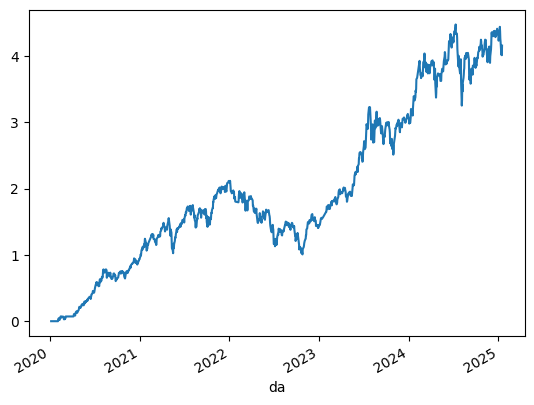

In [142]:
# signal_df.loc['123'] = ""
# signal_df = signal_df.shift(1).iloc[1:, :]
# signal_df

def holdings_dict_to_filtered_holdings_dict(holdings_dict):
    filtered_holdings_dict = {}
    keys_list = list(holdings_dict.keys())
    values_list = list(holdings_dict.values())
    prev_h = ""
    signal_already_0 = False
    # using trading days for market_bullbear to loop
    for current_date in list(signal_df.index):
        # store the current signal
        signal = signal_df.loc[current_date].values[0]

        list_diff = [(k - current_date).days for k in keys_list]
        argmin = np.argmin(np.abs(list_diff))
        if (current_date - keys_list[argmin]).days > 0: h = values_list[argmin]
        else: h = values_list[argmin-1]
        if signal != 0 and prev_h != h: 
            filtered_holdings_dict[current_date] = h; prev_h = h;
        elif signal == 0 and not signal_already_0:
            filtered_holdings_dict[current_date] = {}; signal_already_0 = True;
        elif signal != 0 and signal_already_0:
            filtered_holdings_dict[current_date] = h; prev_h = h; signal_already_0 = False;
    return filtered_holdings_dict
def from_holdings_dict_to_cumsum_return(pivoted_df, new_holding_dict):
    prev = ""
    list_cumsum = []
    for index, (date, holdings) in enumerate(new_holding_dict.items()):
        if index == 0: prev = date; continue;
        cur = pivoted_df[list(holdings)].loc[prev:date]
        cur_nplog = np.log(cur / cur.shift(1)).fillna(0).iloc[1:, :]
        list_cumsum.append(cur_nplog.mean(axis=1))
        prev = date
    return list_cumsum
unfiltered_pivoted_df = unpivoted_df.pivot_table(index='da', values='nav', columns="code")
list_cumsum = from_holdings_dict_to_cumsum_return(pivoted_df, holdings_dict)
((1 + pd.concat(list_cumsum).fillna(0)).cumprod()-1).plot()


In [143]:
holdings_dict

{Timestamp('2020-01-03 00:00:00'): {'13539952', '13984165', '13986924'},
 Timestamp('2020-02-03 00:00:00'): {'98638804', '98639111', '98639235'},
 Timestamp('2020-03-05 00:00:00'): {'18480065', '20081352', '97988636'},
 Timestamp('2020-04-06 00:00:00'): {'98638804', '98639886', '98639887'},
 Timestamp('2020-05-15 00:00:00'): {'73989501', '92002384', '97988636'},
 Timestamp('2020-06-24 00:00:00'): {'81585475', '97988636', '98638805'},
 Timestamp('2020-08-10 00:00:00'): {'17146752', '19330754', '98638805'},
 Timestamp('2020-09-10 00:00:00'): {'13986924', '19330754', '98638805'},
 Timestamp('2020-10-12 00:00:00'): {'13986924', '19330754', '98638805'},
 Timestamp('2020-12-09 00:00:00'): {'13986924', '19330754', '98638805'},
 Timestamp('2021-04-23 00:00:00'): {'13986924', '19330754', '98638805'},
 Timestamp('2021-05-27 00:00:00'): {'19330754', '92002244', '98638805'},
 Timestamp('2021-06-28 00:00:00'): {'13986924', '92002244', '98638805'},
 Timestamp('2021-08-30 00:00:00'): {'13986924', '73

In [ ]:
# origin: ignores fees and changes on demand
def easy_breakout(df, beck, top_n=1, type_="AE21"):
   
    tdf = df.ffill().fillna(0)
    
    pct_change = tdf.pct_change()
    pct_change[(pct_change > 0.1) | (pct_change < -0.1)] = 0 
   
    holdings = []
    cumulative_returns = pd.DataFrame(index=tdf.index)  

   
    for i in range(1, len(tdf)):
        cumulative_returns = cumulative_returns.shift(1).fillna(0) + pct_change
        best_stocks = cumulative_returns.iloc[i].nlargest(top_n).index 
        holdings.append(list(best_stocks)) 
    
    i = 20
    pct_change = pct_change.shift(i)
    pct_change['Best_Holding'] = [None] + holdings
    holds = ""
    holdings_dict = {}
    
    for index, row in pct_change[['Best_Holding']].iterrows():
        if row['Best_Holding'] == None: continue
        current_holdings = set(row['Best_Holding']) 
        if holds != current_holdings:
            holdings_dict[index] = current_holdings 
            holds = current_holdings

    pct_change = pct_change.iloc[2+i:, :]
        
    pct_change['ret'] = pct_change.apply(lambda row: row[row['Best_Holding']].mean(), axis=1)
   
    fig = go.Figure()
   
    fig.add_trace(go.Scatter(
        x=pct_change.index,
        y=pct_change['ret'].cumsum(),
        mode="lines",
        line=dict(color="green"),
        yaxis="y1",
        name="Strategy Return"
    ))

    beck = beck.loc[:].pct_change().cumsum()
    beck.columns = ['pct_change']
    fig.add_trace(go.Scatter(
        x=pct_change.index,
        y=beck["pct_change"],
        name="Benchmark",
        mode="lines",
        line=dict(color="orange"),
        yaxis="y1"
    ))
    
    fig.update_layout(
        title="Strategy and Benchmark Performance",
        xaxis=dict(title="Date"),
        yaxis=dict(
            title="Strategy Return",
            titlefont=dict(color="blue"),
            tickfont=dict(color="blue"),
        ),
        yaxis2=dict(
            title="Benchmark",
            titlefont=dict(color="orange"),
            tickfont=dict(color="orange"),
            overlaying="y", 
            side="right" 
        ),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        template="plotly_white"
    )

    fig.show()
    return holdings_dict

beck = yf.download("0050.TW", start='2020-01-01', progress=False, rounding=2)[['Adj Close']]
holdings_dict = easy_breakout(pivoted_df, beck, top_n=3, type_='AA2')


In [ ]:
# type 2: regime + turbulence
from numpy.linalg import LinAlgError #type: ignore
def calculate_turbulence(holding_df):
    for i in range(len(holding_df)):
        temp = holding_df.iloc[i:init+i, :]
        index = temp.index[-1]
        temp_arr = np.array(temp)
        m = np.mean(temp_arr, axis=0)
        c = temp.cov()
        try:
            turbulence = m.T @ np.linalg.inv(c) @ m
            turbulences[index] = turbulence
        except LinAlgError:
            turbulences[index] = 0
            print(1)
    return pd.DataFrame([turbulences]).T
iter = 0
prev = None
holding_dict = {}
for da, holding in holdings_dict.items():
    if not prev: holding_dict[da] = holding; prev = holding;
    # test whether modify position or not
    else:
        prev_holding = pct_change[list(prev)].loc[:da]
        curr_holding = pct_change[list(holding)].loc[:da]
        prev_turbulence = calculate_turbulence(prev_holding)
        curr_turbulence = calculate_turbulence(curr_holding)
        break
init = 20
turbulences = {}

for i in range(len(temp_df)):
    temp = temp_df.iloc[i:init+i, :]
    index = temp.index[-1]
    temp_arr = np.array(temp)
    m = np.mean(temp_arr, axis=0)
    c = temp.cov()
    try:
        turbulence = m.T @ np.linalg.inv(c) @ m
        turbulences[index] = turbulence
    except LinAlgError:
        turbulences[index] = 0
        print(1)